In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
!python3 -m pip install --upgrade pip
!pip install --upgrade torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [4]:
print(torch.__version__)

2.0.0+cu117


In [5]:
%matplotlib inline

In [ ]:
import os

modelname="4_22_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [9]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [11]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [12]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [13]:
def generate(seed: str, cutoff: int = 128) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [14]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [15]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [16]:
n_features = 256 # No. of tokens
embedding_dim = 640
train_split = 0.75
batch_size = 128
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 8

In [17]:
path_to_data = "data/numbers.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\n")))
random.shuffle(data_split)

n = int(train_split * len(data_split))
print(n)
train_data = data_split[:n]
val_data = data_split[n:]

train_dataloader = TextDataset(train_data, n_features)
test_dataloader = TextDataset(train_data, n_features)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

950424


In [18]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [19]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 256])
torch.Size([1, 256, 256])
tensor([[198, 158,  39,  28, 249, 119, 161, 252, 103, 163, 197, 177, 103, 112,
           3, 254, 138,  98,  98, 196, 175, 175, 175, 175, 175, 175, 175, 175,
         175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,  65, 175, 175,
         175, 199,  65,  65,  65, 163,  65, 175,  65, 175,  65,  65,  65,  65,
          65, 175, 175, 175, 175, 175, 175,  65,  65,  65,  65, 161, 163, 175,
         175, 175, 175,  37, 175, 111, 175, 199, 242, 161,  81,  37,  65,  65,
         175, 161, 175, 175, 175,  65, 148,  65,  37,  37,  37,  37,  68,  37,
         163, 175, 163, 175,  65,  65,  65,  65,  65, 233,  65, 175, 175, 175,
         175,  65, 242, 233,  65,  65,  65, 163,  65, 163, 163,  65,  65,  65,
          65,  65,  65,  65,  65,  65, 175, 175, 175,  65,  65,  65,  65, 175,
          65,  65,  65,  65,  65,  65, 175,  65,  65,  65,  65,  65, 175, 163,
         175,  65, 233,  65,  65,  65,  65,  65,  65, 175,  65,  65,  65,  65,
     

In [20]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
n_epochs = 40

In [22]:
!nvidia-smi

Sat Apr 22 18:54:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   35C    P0    55W / 150W |   1155MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
prompts = [
    "What is 1+2?",
    "Compute 1 plus 2:",
    "What is 3-2?",
    "Compute 3 minus 2:",
    "What is 3*4?",
    "Compute 3 times 4:",
    "What is 4/2?",
    "Compute 4 divided by 2:",
]

Epoch 1


100%|██████████| 7426/7426 [1:15:45<00:00,  1.63it/s]


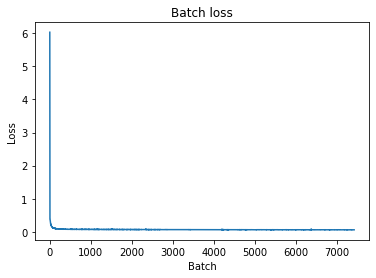

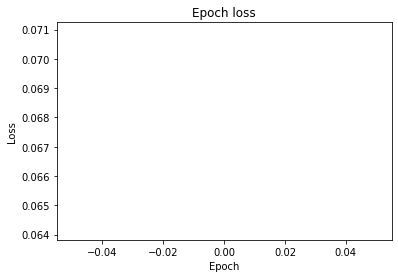

Prompt 0: What is 1+2?
Model output: What is 1+2? 11

Prompt 1: Compute 1 plus 2:
Model output: Compute 1 plus 2: 11

Prompt 2: What is 3-2?
Model output: What is 3-2? -1

Prompt 3: Compute 3 minus 2:
Model output: Compute 3 minus 2: -1

Prompt 4: What is 3*4?
Model output: What is 3*4? 16

Prompt 5: Compute 3 times 4:
Model output: Compute 3 times 4: 16

Prompt 6: What is 4/2?
Model output: What is 4/2? 13

Prompt 7: Compute 4 divided by 2:
Model output: Compute 4 divided by 2: 13

Epoch 2


 16%|█▌        | 1206/7426 [12:18<1:03:29,  1.63it/s]


KeyboardInterrupt: 

In [24]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E9")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [25]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()

>>>  What is 1+3?


Model output: What is 1+3? 1



>>>  What is 1+3?


Model output: What is 1+3? 1



>>>  What is 1+2?


Model output: What is 1+2? 1



>>>  What is 2+1?


Model output: What is 2+1? 1



KeyboardInterrupt: Interrupted by user